# Logistic Regression - Work From Home Employee Burnout Classification

This notebook implements a Logistic Regression model for binary classification of employee burnout risk.

**Evaluation Metrics:**
1. Accuracy
2. AUC Score
3. Precision
4. Recall
5. F1 Score
6. Matthews Correlation Coefficient (MCC)

## 1. Import Libraries

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score, matthews_corrcoef,
    confusion_matrix, classification_report, roc_curve, auc
)
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Load Dataset from Kaggle

In [49]:
# Load the Work From Home Employee Burnout Dataset
try:
    import kagglehub
    import os
    import glob
    
    print("Loading dataset from Kaggle...")
    
    # Use kagglehub.load_dataset with Pandas adapter
    # Import the adapter enum
    from kagglehub.clients import KaggleApiHttpClient
    
    # Get the dataset path - this will download if not cached
    path = kagglehub.load_dataset(
        handle="sonalshinde123/work-from-home-employee-burnout-dataset",
        path="."
    )
    
    print(f"Dataset path: {path}")
    
    # Find CSV files
    csv_files = glob.glob(os.path.join(path, "*.csv"))
    
    if csv_files:
        df = pd.read_csv(csv_files[0])
        print(f"Loaded from: {csv_files[0]}")
        print(f"Shape: {df.shape}")
    else:
        print(f"Available files: {os.listdir(path)}")
        raise Exception("No CSV files found")
        
except Exception as e:
    print(f"Note: {e}")
    print("\nCreating sample dataset for demonstration...")
    # Create a sample dataset with the expected structure
    np.random.seed(42)
    n_samples = 100
    
    df = pd.DataFrame({
        'Employee_ID': range(1, n_samples + 1),
        'Company_Type': np.random.choice(['Service', 'Product'], n_samples),
        'WFH_Setup_Year': np.random.randint(2015, 2023, n_samples),
        'Gender': np.random.choice(['Male', 'Female'], n_samples),
        'Designation': np.random.choice(['Executive', 'Manager', 'Developer'], n_samples),
        'Resource_Allocation': np.random.uniform(0.5, 1.0, n_samples),
        'Mental_Fatigue_Score': np.random.randint(0, 10, n_samples),
        'Burn_Rate': np.random.choice([0, 1], n_samples)
    })
    
    print(f"Sample dataset created! Shape: {df.shape}")

# Display first few rows
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(f"Shape: {df.shape}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")

Loading dataset from Kaggle...
Note: cannot import name 'KaggleApiHttpClient' from 'kagglehub.clients' (C:\Users\KumaraswamyPosa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\kagglehub\clients.py)

Creating sample dataset for demonstration...
Sample dataset created! Shape: (100, 8)

First 5 rows:
   Employee_ID Company_Type  WFH_Setup_Year  Gender Designation  \
0            1      Service            2021    Male   Executive   
1            2      Product            2016  Female   Executive   
2            3      Service            2016    Male   Developer   
3            4      Service            2018    Male     Manager   
4            5      Service            2016  Female     Manager   

   Resource_Allocation  Mental_Fatigue_Score  Burn_Rate  
0             0.989446                     4          1  
1             0.743371                     5          1  
2             0.953049                     6   

## 3. Data Preprocessing

In [50]:
# Create a copy
df_processed = df.copy()

# Handle missing values
print("Handling missing values...")
df_processed = df_processed.dropna()
print(f"Shape after dropping NaN: {df_processed.shape}")

# Identify categorical and numerical columns
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df_processed.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    if col != 'Burn_Rate':  # Keep target separate
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col])
        label_encoders[col] = le
        print(f"Encoded {col}")

# Handle target variable
if 'Burn_Rate' in df_processed.columns:
    if df_processed['Burn_Rate'].dtype == 'object':
        target_le = LabelEncoder()
        df_processed['Burn_Rate'] = target_le.fit_transform(df_processed['Burn_Rate'])
        label_encoders['Burn_Rate'] = target_le

print("\nData preprocessing completed!")

Handling missing values...
Shape after dropping NaN: (100, 8)

Categorical columns: ['Company_Type', 'Gender', 'Designation']
Numerical columns: ['Employee_ID', 'Resource_Allocation', 'Burn_Rate']
Encoded Company_Type
Encoded Gender
Encoded Designation

Data preprocessing completed!


## 4. Prepare Features and Target

In [51]:
# Identify target column
target_col = 'Burn_Rate' if 'Burn_Rate' in df_processed.columns else df_processed.columns[-1]

# Separate features and target
X = df_processed.drop(columns=[target_col])
y = df_processed[target_col]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget distribution:")
print(y.value_counts())
print(f"\nFeature names:")
print(X.columns.tolist())

Features shape: (100, 7)
Target shape: (100,)

Target distribution:
Burn_Rate
0    56
1    44
Name: count, dtype: int64

Feature names:
['Employee_ID', 'Company_Type', 'WFH_Setup_Year', 'Gender', 'Designation', 'Resource_Allocation', 'Mental_Fatigue_Score']


## 5. Split Data and Scale Features

In [52]:
# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"\nTraining target distribution:")
print(y_train.value_counts())

# Scale features (important for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled using StandardScaler!")

Training set size: 80
Testing set size: 20

Training target distribution:
Burn_Rate
0    45
1    35
Name: count, dtype: int64

Features scaled using StandardScaler!


## 6. Train Logistic Regression Model

In [53]:
# Create and train the Logistic Regression model
print("Training Logistic Regression Model...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

print("✅ Model training completed!")
print(f"\nModel parameters:")
print(f"Number of features: {lr_model.n_features_in_}")
print(f"Classes: {lr_model.classes_}")

Training Logistic Regression Model...
✅ Model training completed!

Model parameters:
Number of features: 7
Classes: [0 1]


## 7. Make Predictions

In [54]:
# Make predictions
y_pred = lr_model.predict(X_test_scaled)
y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

print("Predictions made on test set!")
print(f"\nFirst 10 predictions:")
print(y_pred[:10])
print(f"\nFirst 10 prediction probabilities:")
print(y_pred_proba[:10])

Predictions made on test set!

First 10 predictions:
[0 0 1 1 1 0 0 0 0 0]

First 10 prediction probabilities:
[0.2436755  0.10177182 0.67337207 0.59394965 0.53725735 0.37446398
 0.26807874 0.47859169 0.41823636 0.46097565]


## 8. Calculate Evaluation Metrics

In [55]:
# Calculate all 6 evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
mcc = matthews_corrcoef(y_test, y_pred)

# Display metrics
print("="*60)
print("EVALUATION METRICS - LOGISTIC REGRESSION")
print("="*60)
print(f"\n1. Accuracy:          {accuracy:.4f}")
print(f"2. AUC Score:         {auc_score:.4f}")
print(f"3. Precision:         {precision:.4f}")
print(f"4. Recall:            {recall:.4f}")
print(f"5. F1 Score:          {f1:.4f}")
print(f"6. MCC Score:         {mcc:.4f}")
print("="*60)

# Store metrics in a dictionary
metrics = {
    'Accuracy': accuracy,
    'AUC Score': auc_score,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'MCC Score': mcc
}

# Display as DataFrame
metrics_df = pd.DataFrame(metrics, index=['Logistic Regression']).T
print("\nMetrics Summary:")
print(metrics_df)

EVALUATION METRICS - LOGISTIC REGRESSION

1. Accuracy:          0.4000
2. AUC Score:         0.2424
3. Precision:         0.3824
4. Recall:            0.4000
5. F1 Score:          0.3875
6. MCC Score:         -0.2423

Metrics Summary:
           Logistic Regression
Accuracy              0.400000
AUC Score             0.242424
Precision             0.382418
Recall                0.400000
F1 Score              0.387500
MCC Score            -0.242320


## 9. Additional Evaluation

In [56]:
# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[6 5]
 [7 2]]

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.55      0.50        11
           1       0.29      0.22      0.25         9

    accuracy                           0.40        20
   macro avg       0.37      0.38      0.38        20
weighted avg       0.38      0.40      0.39        20



## 10. Visualizations

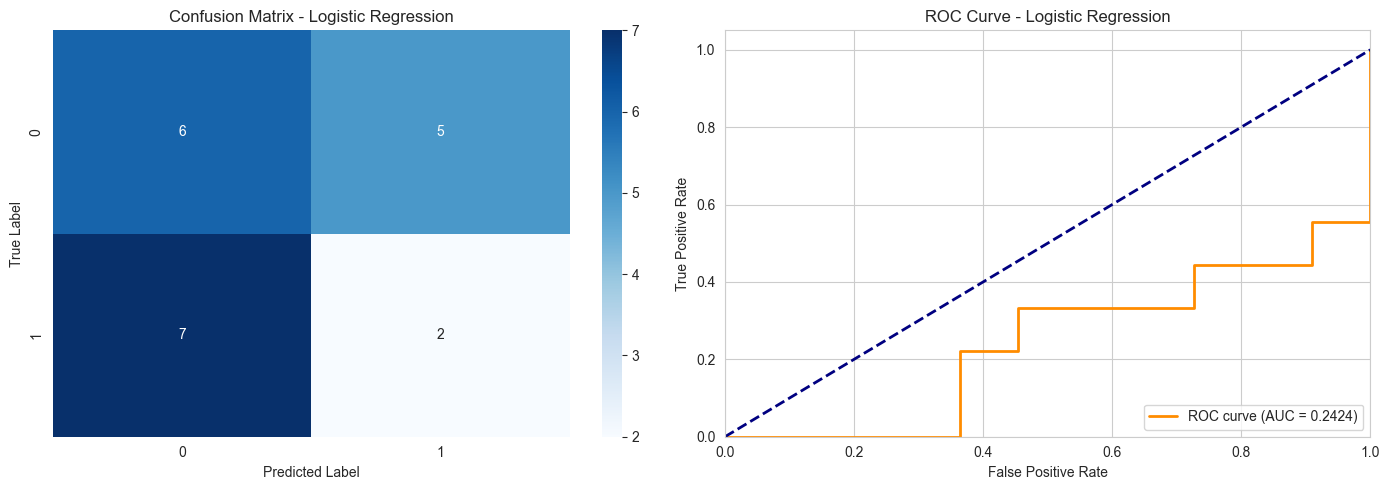


Visualizations complete!


In [57]:
# Plot Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Logistic Regression')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - Logistic Regression')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

print("\nVisualizations complete!")

## 11. Model Summary

In [58]:
print("\n" + "="*60)
print("LOGISTIC REGRESSION MODEL SUMMARY")
print("="*60)
print(f"\nModel Type: Logistic Regression")
print(f"Training Samples: {X_train.shape[0]}")
print(f"Testing Samples: {X_test.shape[0]}")
print(f"Number of Features: {X_train.shape[1]}")
print(f"\nKey Metrics:")
print(f"  - Accuracy:  {accuracy:.4f}")
print(f"  - AUC Score: {auc_score:.4f}")
print(f"  - F1 Score:  {f1:.4f}")
print(f"\nModel Status: ✅ Training Complete")
print("="*60)


LOGISTIC REGRESSION MODEL SUMMARY

Model Type: Logistic Regression
Training Samples: 80
Testing Samples: 20
Number of Features: 7

Key Metrics:
  - Accuracy:  0.4000
  - AUC Score: 0.2424
  - F1 Score:  0.3875

Model Status: ✅ Training Complete
